In [16]:
import numpy as np

from sklearn.cluster import DBSCAN, AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from random import randrange
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
import matplotlib
from itertools import cycle
import numpy as np
import random

In [17]:
# Date generation functions
def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)


def date_to_days(start, date):
    """
    This function returns number of days elapsed
    """
    delta = date - start
    return float(delta.days)

def time_to_seconds(date):
    """
    Function returns time of the day in seconds"""
    td = date.time()
    return ((td.hour * 3600 + td.second) * 10**6 + td.microsecond) / 10**6
def time_to_hours(date):
    """
    Function returns time of the day in hours"""
    td = date.time()
    return float(td.hour)


In [18]:
# Generate data
# colors
def gen_colors(n):
  ret = []
  r = int(random.random()*10)/10
  g = int(random.random()*10)/10
  b = int(random.random()*10)/10
  step = 256 / n
  for i in range(n):
    r += i*0.01
    g += i*0.01
    b += i*0.01
    r = (r)%1
    g = (g)%1
    b = (b)%1
    ret.append((r,g,b)) 
  return ret

#Sample blobs
def gen_blobs(nb_points):
    centers = [[1, 1], [-1, -1], [1, -1]]
    X, labels_true = make_blobs(n_samples=nb_points, centers=centers, cluster_std=0.5,
                            random_state=0)
    return X, labels_true

#Sample dates,times
def gen_dt(nb_points):
    start1 = datetime(1943,3, 13, 19,40,6)
    end1 = start1 + timedelta(days=40)
    start2 = datetime(1943,4, 15, 20,43,6)
    end2 = start2 + timedelta(days=200)
    start3 = datetime(1943,4, 25, 1,1,1)
    end3 = start3 + timedelta(days=50)
    days = []
    times = []
    #Generate datetimes 
    for i in range(int(nb_points*20/100)):
        random_dt1 = random_date(start1, end1)
        #date = time.second(random_dt.timetuple())
        days.append(date_to_days(start1,random_dt1))
        times.append(time_to_hours(random_dt1))
    for i in range(int(nb_points*50/100)):
        random_dt2 = random_date(start2, end2)
        #date = time.second(random_dt.timetuple())
        days.append(date_to_days(start1,random_dt2))
        times.append(time_to_hours(random_dt2)) 
    for i in range(int(nb_points*30/100)):
        random_dt3 = random_date(start3, end3)
        #date = time.second(random_dt.timetuple())
        days.append(date_to_days(start1,random_dt3))
        times.append(time_to_hours(random_dt3)%5+10)
    X = days,times
    X = np.array((days,times))
    #X = X.reshape(n_samples,2)
    X = X.transpose()
    print(X.shape)
    return X

In [19]:
# Fit models

# Compute Affinity Propagation
def compute_AP(features):
    af = AffinityPropagation(preference=-100,damping=0.6).fit(features)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    return cluster_centers_indices, labels

def compute_DBSCAN(features):
    features = StandardScaler().fit_transform(features)
    # #############################################################################
    # Compute DBSCAN
    db = DBSCAN(eps=0.2, min_samples=2).fit(features)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    return core_samples_mask, labels

In [23]:
# Plot models
def plot_AP(features, cci,labels_AP):
    
    n_clusters_ = len(cci)
    
    #cmap = plt.get_cmap('hsv')
    #colors = cmap(np.linspace(0, 1.0, n_clusters_))
    #colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    #colors = colors(250)
    colors = gen_colors(n_clusters_)
    
    for k, my_col in zip(range(n_clusters_), colors):
        class_members = labels_AP == k
        cluster_center = features[cci[k]]
        col = matplotlib.colors.to_hex((my_col))
        plt.plot(features[class_members, 0], features[class_members, 1], col)
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
        for x in features[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    plt.title('Estimated number of clusters for Affinity propagation: %d' % n_clusters_)
    plt.xlabel("days")
    plt.ylabel("hours")
    plt.show()

def plot_original(features):
    plt.close('all')
    plt.figure(1)
    plt.clf()


    plt.title('original')
    plt.xlabel("days")
    plt.ylabel("hours")
    plt.plot(features[:, 0], features[:, 1], 'b.')
    plt.show()
    
def plot_DBSCAN(features,core_samples_mask_dbscan, labels_dbscan):
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
    # Black removed and is used for noise instead.
    unique_labels = set(labels_dbscan)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels_dbscan == k)

        xy = features[class_member_mask & core_samples_mask_dbscan]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = features[class_member_mask & ~core_samples_mask_dbscan]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters for DBSCAN: %d' % n_clusters_)
    plt.xlabel("days")
    plt.ylabel("hours")
    plt.show()   

In [24]:
def process(nb_points):
    #generate data
    X = gen_dt(nb_points)
    plot_original(X)
    # Affinity propagation
    cluster_centers_indices, labels = compute_AP(X)
    plot_AP(X,cluster_centers_indices,labels)
    # dbscan
    core_samples_mask,labels = compute_DBSCAN(X)
    plot_DBSCAN(X,core_samples_mask,labels)


(50, 2)


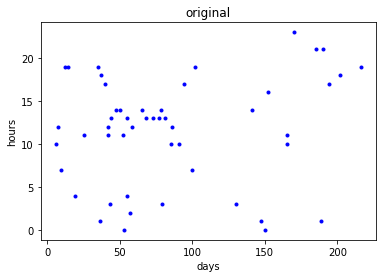

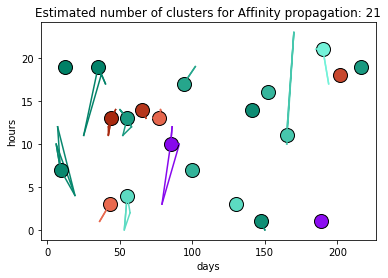

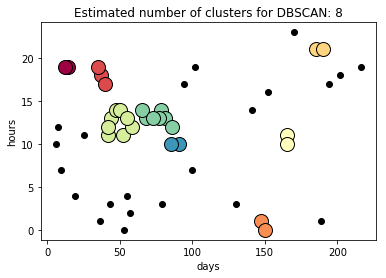

In [25]:
# process affinity propagation and dbscan clustering methods for 120 points
n_samples = 50
process(n_samples)

(300, 2)


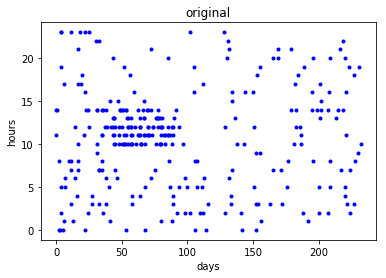

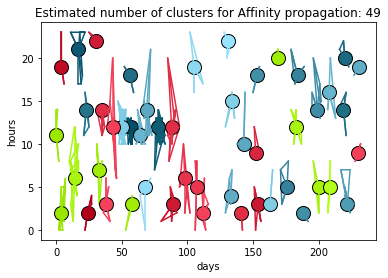

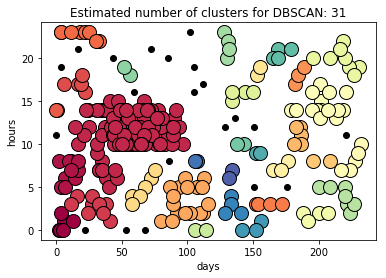

In [26]:
# process affinity propagation and dbscan clustering methods for 1200 points
points = 300
process(points)

In [27]:
#We will use DBSCAN for habit mining, as it determines more suitable habits from the groups we can see above